# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, desc, sum as Fsum, avg, count, max as Fmax, min, col, last, regexp_extract
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler, Normalizer
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
#choose the mini dataset
event_data = "mini_sparkify_event_data.json"

In [5]:
# load the data into spark
df = spark.read.json(event_data)
df.persist()
df.head()
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# Number of rows
df.count()

286500

In [7]:
# get an overview of all columns, use a for loop so the display of each column is in its own "table", which makes it more readable than
# the default "wide" view of df.describe()
for c in df.columns:
    df.describe(c).show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161377|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+

+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev| 129.7672620114106|
|    min|                 0|
|    max| 

In [8]:
# remove records with a missing userId or sessionId
df = df.dropna(how="any", subset=["userId", "sessionId"])

In [9]:
# print the count of remaining rows
df.count()

286500

**No rows were removed, which means there is no null values in the userId or sessionId fields**

In [10]:
# identify records with invalid value of userId
df.groupBy("userId").count().orderBy("userId").show()

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
|    10|  795|
|   100| 3214|
|100001|  187|
|100002|  218|
|100003|   78|
|100004| 1245|
|100005|  216|
|100006|   44|
|100007|  520|
|100008|  940|
|100009|  671|
|100010|  381|
|100011|   23|
|100012|  600|
|100013| 1392|
|100014|  310|
|100015| 1050|
|100016|  638|
|100017|   75|
+------+-----+
only showing top 20 rows



In [11]:
# remove the rows with an empty userId. This will exclude all logged out users from the remainder of the analysis
df = df.filter(df["userId"]!="")

# print the count of remaining rows
df.count()

278154

In [12]:
# show records with invalud value of sessionId
df.groupBy("sessionId").count().orderBy("sessionId").show()

+---------+-----+
|sessionId|count|
+---------+-----+
|        1|  680|
|        2|    7|
|        3|   37|
|        4|   24|
|        5|   57|
|        6|   68|
|        7|    1|
|        8|   45|
|        9|  190|
|       10|  165|
|       11|   46|
|       12|   59|
|       13|  119|
|       15|  213|
|       16|   39|
|       17|  169|
|       18|   27|
|       19|  151|
|       20|   29|
|       21|  127|
+---------+-----+
only showing top 20 rows



**There are no invalid values in the sessionId column**


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.


**In the following section we will explore the data to get a feeling of how it is structured, and understand the specific information that could help us identify when a user would churn or not:**

In [13]:
# display the possible pages used in the dataset
df.select("page").dropDuplicates().sort("page").show(30)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [14]:
# display the possible auth values used in the dataset
df.select("auth").dropDuplicates().sort("auth").show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [15]:
# display the possible levels used in the dataset
df.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [16]:
# display the possible values for the platform, extracted from user agent field
# prepare a regex extraction function
re = regexp_extract("userAgent", r'[^(]*\(([^ ;]*)', 1).alias("platform")

# replace the common platforms with an aggregated dataset to identify the technology "world" the user lives in
df.select(re).replace(["iPad","iPhone","Macintosh","X11","Windows","compatible"],
                      ["Apple","Apple","Apple","Linux","Windows","Windows"], "platform").dropDuplicates().show()

+--------+
|platform|
+--------+
|   Linux|
|   Apple|
| Windows|
+--------+



In [17]:
# identify the pages associated with a given HTTP method
df.groupBy(["page","method"]).count().orderBy("page").show(30)

+--------------------+------+------+
|                page|method| count|
+--------------------+------+------+
|               About|   GET|   495|
|          Add Friend|   PUT|  4277|
|     Add to Playlist|   PUT|  6526|
|              Cancel|   PUT|    52|
|Cancellation Conf...|   GET|    52|
|           Downgrade|   GET|  2055|
|               Error|   GET|   252|
|                Help|   GET|  1454|
|                Home|   GET| 10082|
|              Logout|   PUT|  3226|
|            NextSong|   PUT|228108|
|         Roll Advert|   GET|  3933|
|       Save Settings|   PUT|   310|
|            Settings|   GET|  1514|
|    Submit Downgrade|   PUT|    63|
|      Submit Upgrade|   PUT|   159|
|         Thumbs Down|   PUT|  2546|
|           Thumbs Up|   PUT| 12551|
|             Upgrade|   GET|   499|
+--------------------+------+------+



**Each page is associated only with a defined method. Therefore the method column does not provide additional information on the usage of the site by users, it is only a technical object that is linked to the way the page is implemented**

In [18]:
# show the number of unique users
df.select("userId").dropDuplicates().count()

225

In [19]:
# show the number of unique registrations
df.select("registration").dropDuplicates().count()

225

In [20]:
# identify if there is a 1:1 match between userId and registration
df.select(["userId","registration"]).dropDuplicates().count()

225

**The fact that the following values are equal mean there is a 1:1 relationship between userId and registration,
Registration also seems to be only a technical identifier that does not provide additional information on top of the userId field**

In [21]:
# explore sessionId field
df.groupBy(["userId","sessionId"]).count().orderBy(["userId","sessionId"]).show()

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    10|        9|   70|
|    10|      595|  449|
|    10|     1047|   25|
|    10|     1414|   78|
|    10|     1592|   78|
|    10|     1981|   95|
|   100|      256|  177|
|   100|      369|  108|
|   100|      435|   17|
|   100|      556|  287|
|   100|      683|   32|
|   100|      707|  220|
|   100|      991|   20|
|   100|     1049|   82|
|   100|     1185|  170|
|   100|     1210|   80|
|   100|     1231|   18|
|   100|     1269|    5|
|   100|     1279|   31|
|   100|     1299|   96|
+------+---------+-----+
only showing top 20 rows



**each user is having multiple sessions, with a variable number of actions during each session**

In [22]:
# display the possible pages status used in the dataset
df.select("status").dropDuplicates().sort("status").show()

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



**HTTP statuses reference is available on https://httpstatuses.com/**

**Specifically for the ones available in the above table:**

* https://httpstatuses.com/200 - page ok

* https://httpstatuses.com/307 - temporary redirect

* https://httpstatuses.com/404 - page not found

In [23]:
# Show the pages with a redirect
df.filter(df["status"]=="307").groupBy(["auth","page"]).count().orderBy("auth").show()

+---------+----------------+-----+
|     auth|            page|count|
+---------+----------------+-----+
|Logged In|          Logout| 3226|
|Logged In|       Thumbs Up|12551|
|Logged In|  Submit Upgrade|  159|
|Logged In|     Thumbs Down| 2546|
|Logged In|      Add Friend| 4277|
|Logged In|   Save Settings|  310|
|Logged In|          Cancel|   52|
|Logged In|Submit Downgrade|   63|
+---------+----------------+-----+



In [24]:
# Show the pages with an Error
df.filter(df["status"]=="404").groupBy(["auth","page"]).count().orderBy("auth").show()

+---------+-----+-----+
|     auth| page|count|
+---------+-----+-----+
|Logged In|Error|  252|
+---------+-----+-----+



In [25]:
# example of a user with error in the activities
df.filter(df["status"]=="404").show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method| page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|     Kael|     M|           48|   Baker|  null| paid|Kingsport-Bristol...|   GET|Error|1533102330000|      249|null|   404|1538393848000|"Mozilla/5.0 (Mac...|   131|
|  null|Logged In|   Lucero|     F|           10|    Reed|  null| free|Louisville/Jeffer...|   GET|Error|1536642109000|      139|null|   404|1538407927000|"Mozilla/5.0 (Win...|   140|
|  null|Logged In|Sebastian|     M|           38|    Wang|  null| free|         

In [26]:
df.select(["userId", "firstname", "sessionId", "auth", "page", "status", "level", "song"]).where(df.userId == "17").show()

+------+---------+---------+---------+-----------+------+-----+--------------------+
|userId|firstname|sessionId|     auth|       page|status|level|                song|
+------+---------+---------+---------+-----------+------+-----+--------------------+
|    17|    Kayla|      250|Logged In|       Home|   200| free|                null|
|    17|    Kayla|      250|Logged In|   NextSong|   200| free|      Pork And Beans|
|    17|    Kayla|      250|Logged In|   NextSong|   200| free|Pursuit Of Happin...|
|    17|    Kayla|      250|Logged In|   NextSong|   200| free|     God Isn't Dead?|
|    17|    Kayla|      250|Logged In|   NextSong|   200| free|        By My Spirit|
|    17|    Kayla|      250|Logged In|   NextSong|   200| free|Best Imitation Of...|
|    17|    Kayla|      250|Logged In|   NextSong|   200| free|Language Lessons ...|
|    17|    Kayla|      250|Logged In|Roll Advert|   200| free|                null|
|    17|    Kayla|      250|Logged In|   NextSong|   200| free|Ta

In [27]:
# show users who have changes status during the period captured in the dataset
df.withColumn("userId", df["userId"].cast(IntegerType())).groupBy(["userId","level","auth"]).count().orderBy("userId").show()

+------+-----+---------+-----+
|userId|level|     auth|count|
+------+-----+---------+-----+
|     2| paid|Logged In|  899|
|     3| paid|Logged In|  253|
|     3| paid|Cancelled|    1|
|     4| free|Logged In|  141|
|     4| paid|Logged In| 2301|
|     5| free|Logged In|  218|
|     6| free|Logged In|   84|
|     6| paid|Logged In| 3677|
|     7| free|Logged In|  201|
|     8| free|Logged In|  334|
|     9| paid|Logged In| 2934|
|     9| free|Logged In|  257|
|    10| paid|Logged In|  795|
|    11| paid|Logged In|  229|
|    11| free|Logged In|  619|
|    12| paid|Cancelled|    1|
|    12| free|Logged In|  442|
|    12| paid|Logged In|  621|
|    13| paid|Logged In|  452|
|    13| free|Logged In| 1202|
+------+-----+---------+-----+
only showing top 20 rows



### Define Churn:
**After this preliminary analysis, we will create a column churn to use as the label for the model. We will be using the Cancellation Confirmation events to define churn, which happen for both paid and free users.**

In [28]:
# Add the Churn column
flag_cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", flag_cancel_event("page"))

# repeat the churn flag for all rows of the users who churned
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churn", Fsum("churn").over(windowval))

In [29]:
# find an example of Cancellation record
df.filter("page = 'Cancellation Confirmation'").head()

Row(artist=None, auth='Cancelled', firstName='Mason', gender='M', itemInSession=10, lastName='Hart', length=None, level='free', location='Corpus Christi, TX', method='GET', page='Cancellation Confirmation', registration=1533157139000, sessionId=174, song=None, status=200, ts=1539318918000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='125', churn=1)

### Exploration:
**We will now perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. We will be exploring aggregates on these two groups of users**

In [30]:
# show an example of a user journey to Cancellation, this will be displayed with most recent record ("cancellation") on top
df.select(["userId", "sessionId", "ts", "page", "level", "churn"]) \
    .where(df.userId=="18") \
    .where(df.sessionId=="514") \
    .sort("ts", ascending=False) \
    .head(20)

[Row(userId='18', sessionId=514, ts=1538943990000, page='Cancellation Confirmation', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538943740000, page='Cancel', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538943739000, page='Downgrade', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538943726000, page='NextSong', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538943440000, page='NextSong', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538943117000, page='NextSong', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538942837000, page='NextSong', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538942663000, page='NextSong', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538942425000, page='NextSong', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538942030000, page='NextSong', level='paid', churn=1),
 Row(userId='18', sessionId=514, ts=1538941694000, page='NextSon

In [31]:
# count how many users churn vs the others
churn = df.select(["userId", "churn"]).dropDuplicates().groupBy("churn").count()

churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



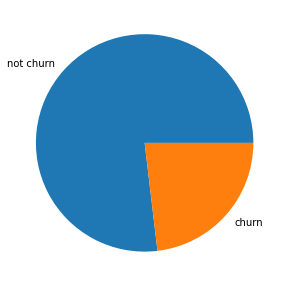

In [32]:
# plot the ratio of users who churn vs. others
pd_df = churn.toPandas()
fig=plt.figure(figsize=(5,5))
plt.pie(x=pd_df["count"], labels=["not churn","churn"]);

**A little less than a 25% of the users perform churn**

In [33]:
# compare the gender of the users who churn vs. users who do not churn
gender = df.select(["userId", "gender", "churn"]).dropDuplicates() \
    .groupBy("churn", "gender").count() \
    .withColumn("percent", col("count")/Fsum("count").over(Window.partitionBy("churn"))) \
    .orderBy(["churn", "gender"])

gender.show()

+-----+------+-----+-------------------+
|churn|gender|count|            percent|
+-----+------+-----+-------------------+
|    0|     F|   84|0.48554913294797686|
|    0|     M|   89| 0.5144508670520231|
|    1|     F|   20|0.38461538461538464|
|    1|     M|   32| 0.6153846153846154|
+-----+------+-----+-------------------+



/Users/mohammed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


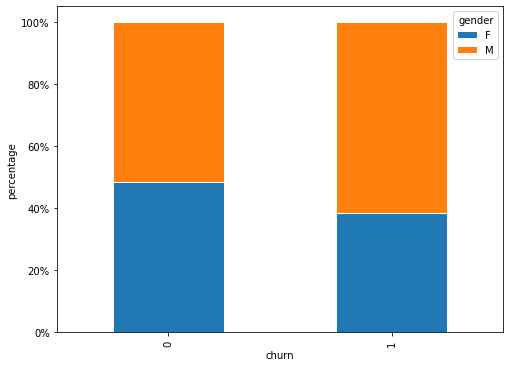

In [34]:
# plot the churn by gender information
pd_df = gender.toPandas()

pd_df = pd_df.pivot(index='churn', columns='gender', values='percent');
pd_df.plot.bar(stacked=True, figsize=(8,6), edgecolor='white');

# do some chart formatting
plt.ylabel("percentage");
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

**The Male population is more likely to churn, relative to the total number of users in their category**

In [35]:
# compare the level (paid/free) of the users who churn vs. users who do not churn
# we want the last level of the user in the dataset, as the level of a user can evolve over time
partition_window = Window.partitionBy(["userId"])

level = df.select(col("userId"), last("level").over(partition_window).alias("level"), col("churn")).dropDuplicates() \
    .groupBy("churn", "level").count() \
    .withColumn("percent", col("count")/Fsum("count").over(Window.partitionBy("churn"))) \
    .orderBy(["churn", "level"])

level.show()

+-----+-----+-----+-------------------+
|churn|level|count|            percent|
+-----+-----+-----+-------------------+
|    0| free|  133| 0.7687861271676301|
|    0| paid|   40|0.23121387283236994|
|    1| free|   44| 0.8461538461538461|
|    1| paid|    8|0.15384615384615385|
+-----+-----+-----+-------------------+



/Users/mohammed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


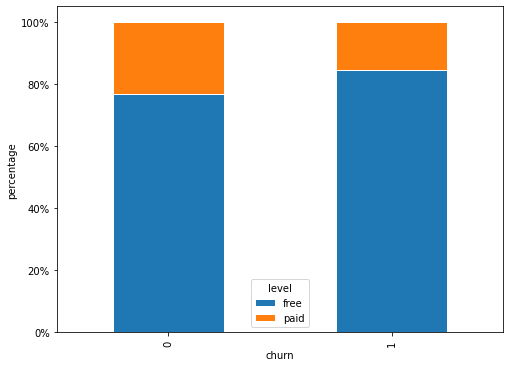

In [36]:
# plot the churn by level information
pd_df = level.toPandas()

pd_df = pd_df.pivot(index='churn', columns='level', values='percent');
pd_df.plot.bar(stacked=True, figsize=(8,6), edgecolor='white');

# do some chart formatting
plt.ylabel("percentage");
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

**The free users are slightly more likely to churn than paid users**

In [37]:
# show total number of different artists that each user listens to
df.filter(df["artist"].isNotNull()) \
    .select(["userId", "artist", "churn"]).dropDuplicates() \
    .groupBy(["churn", "userId"]).agg(count("artist")) \
    .show()

+-----+------+-------------+
|churn|userId|count(artist)|
+-----+------+-------------+
|    0|100010|          252|
|    0|200002|          339|
|    1|   125|            8|
|    0|   124|         2232|
|    1|    51|         1385|
|    0|     7|          142|
|    0|    15|         1302|
|    1|    54|         1744|
|    0|   155|          643|
|    1|100014|          233|
|    0|   132|         1299|
|    0|   154|           78|
|    1|   101|         1241|
|    0|    11|          534|
|    0|   138|         1332|
|    0|300017|         2070|
|    1|100021|          207|
|    1|    29|         1804|
|    0|    69|          865|
|    0|   112|          195|
+-----+------+-------------+
only showing top 20 rows



In [38]:
# show average number of different artists that users listen to between users who churn vs. users who do not churn
diversity = df.filter(df["artist"].isNotNull()) \
    .select(["userId", "artist", "churn"]).dropDuplicates() \
    .groupBy(["churn", "userId"]).agg(count("artist")) \
    .groupBy("churn").agg(avg("count(artist)"))

diversity.show()

+-----+------------------+
|churn|avg(count(artist))|
+-----+------------------+
|    0| 749.7861271676301|
|    1| 518.6923076923077|
+-----+------------------+



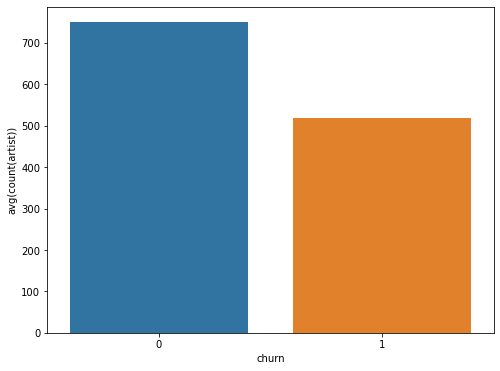

In [39]:
# plot the churn by diversity information
pd_df = diversity.toPandas()
fig=plt.figure(figsize=(8,6))
sns.barplot(x="churn", y="avg(count(artist))", data=pd_df);

**The users who churn are listening to a smaller number of artists over the period of time of the dataset. It is possble that this result is influenced by the fact they are not staying as long on the service, so we will look at the same information, but based on the session instead**

In [40]:
# show average number of different artists per session that users listen to between users who churn vs. users who do not churn
diversity_per_session = df.filter(df["artist"].isNotNull()) \
    .select(["userId", "sessionId", "artist", "churn"]).dropDuplicates() \
    .groupBy(["churn", "userId", "sessionId"]).agg(count("artist")) \
    .groupBy("churn").agg(avg("count(artist)"))

diversity_per_session.show()

+-----+------------------+
|churn|avg(count(artist))|
+-----+------------------+
|    0| 70.10344827586206|
|    1| 65.69171483622351|
+-----+------------------+



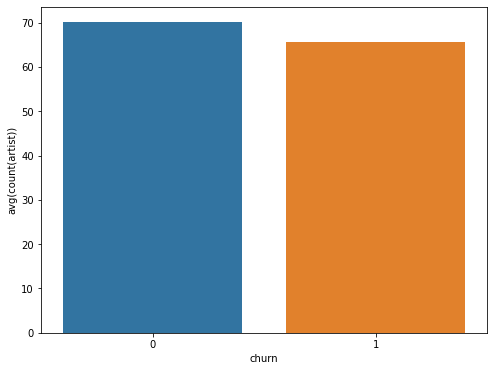

In [41]:
# plot the churn by diversity per sessioninformation
pd_df = diversity_per_session.toPandas()
fig=plt.figure(figsize=(8,6))
sns.barplot(x="churn", y="avg(count(artist))", data=pd_df);

**This chart assures us that the users who churn are listening to a smaller diversity of artists per session.**

In [42]:
# show highest number of times the same artist was played by each user in each session
df.filter(df["artist"].isNotNull()) \
    .groupBy(["churn", "sessionId", "userId", "artist"]).count() \
    .groupBy(["churn","userId", "sessionId"]).agg(Fmax("count")) \
    .orderBy("max(count)", ascending=False).show()

+-----+------+---------+----------+
|churn|userId|sessionId|max(count)|
+-----+------+---------+----------+
|    0|   115|      316|        12|
|    0|    91|     1840|        12|
|    0|    61|      529|        10|
|    0|    41|      377|         9|
|    0|   132|     1494|         8|
|    0|    62|     1150|         7|
|    0|    25|      827|         7|
|    0|   100|      556|         7|
|    0|   128|     2206|         7|
|    0|    95|      541|         7|
|    0|   138|     2305|         7|
|    1|   103|     1117|         7|
|    0|     6|     1199|         7|
|    0|200014|      361|         7|
|    1|   101|      635|         7|
|    0|300002|      436|         7|
|    0|    42|     1646|         7|
|    0|   138|     1305|         7|
|    0|    89|     1271|         7|
|    0|   124|      708|         7|
+-----+------+---------+----------+
only showing top 20 rows



In [43]:
# show average highest number of times the same artist was played by each user in each session between users who churn vs. users who do not churn
repeat_artist_per_session = df.filter(df["artist"].isNotNull()) \
    .groupBy(["churn", "sessionId", "userId", "artist"]).count() \
    .groupBy(["churn", "userId", "sessionId"]).agg(Fmax("count")) \
    .groupBy("churn").agg(avg("max(count)"))

repeat_artist_per_session.show()

+-----+------------------+
|churn|   avg(max(count))|
+-----+------------------+
|    0|1.8875391849529781|
|    1|1.8439306358381502|
+-----+------------------+



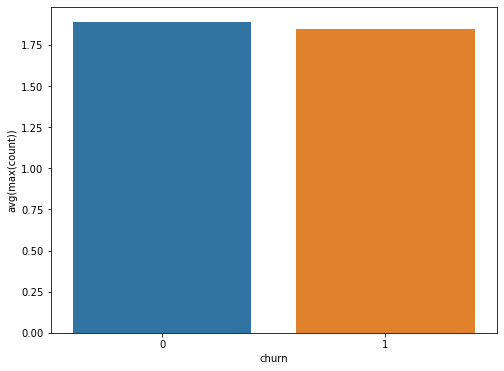

In [44]:
# plot the churn by diversity per session
pd_df = repeat_artist_per_session.toPandas()
fig=plt.figure(figsize=(8,6))
sns.barplot(x="churn", y="avg(max(count))", data=pd_df);

**seems to be no difference on the number of times they listen to songs from the same artist between the churn users and users who continue using the service**

In [45]:
# show the average length of listening each song per user
df.filter(df["artist"].isNotNull()) \
    .groupBy(["userId", "churn"]).agg(avg("length")) \
    .show()

+------+-----+------------------+
|userId|churn|       avg(length)|
+------+-----+------------------+
|100010|    0|  243.421444909091|
|200002|    0|242.91699209302323|
|   125|    1|       261.1391375|
|   124|    0|248.17653659965666|
|    51|    1| 247.8805508289908|
|     7|    0|253.56058066666665|
|    15|    0|249.37701452978044|
|    54|    1|250.38539934530132|
|   155|    0|242.41377060975574|
|100014|    1| 263.4376345525294|
|   132|    0|250.58034431535262|
|   154|    0|245.95266559523813|
|   101|    1| 249.0061294769059|
|    11|    0|246.78510516228766|
|   138|    0|247.56032983574823|
|300017|    0|247.08341966134319|
|100021|    1|250.57902452173914|
|    29|    1|249.18017257925987|
|    69|    0|254.27913390222233|
|   112|    0|246.80347251162794|
+------+-----+------------------+
only showing top 20 rows



In [46]:
# show the average length of listening each song between users who churn vs. users who do not churn
length = df.filter(df["artist"].isNotNull()) \
    .groupBy("churn").agg(avg("length"))

length.show()

+-----+------------------+
|churn|       avg(length)|
+-----+------------------+
|    0|249.20913538880808|
|    1| 248.6327956440622|
+-----+------------------+



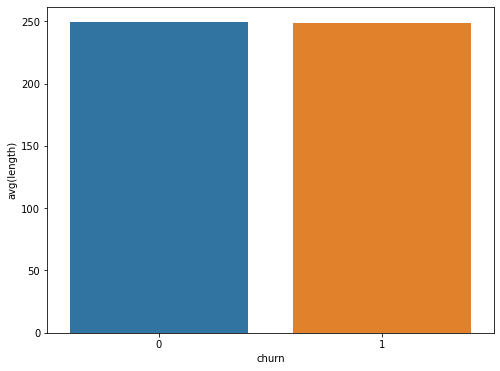

In [47]:
# plot the average length of songs information
pd_df = length.toPandas()
fig=plt.figure(figsize=(8,6))
sns.barplot(x="churn", y="avg(length)", data=pd_df);

**No difference in the length of songs listened to by the 2 groups of users**

In [48]:
# display the possible values for the platform, extracted from user agent field
# prepare a regex extraction function we keep only the first word of the platform
re = regexp_extract("userAgent", r'[^(]*\(([^ ;]*)', 1).alias("platform")

# replace the common platforms with an aggregated dataset to identify the technology "world" the user lives in
platform = df.select([re, "userId", "churn"]) \
    .replace(["iPad", "iPhone", "Macintosh", "X11", "Windows", "compatible"],
             ["Apple", "Apple", "Apple", "Linux", "Windows", "Windows"], "platform").dropDuplicates() \
    .groupBy(["churn", "platform"]).count() \
    .withColumn("percent", col("count")/Fsum("count").over(Window.partitionBy("churn"))) \
    .orderBy("platform")

platform.show()

+-----+--------+-----+-------------------+
|churn|platform|count|            percent|
+-----+--------+-----+-------------------+
|    1|   Apple|   23| 0.4423076923076923|
|    0|   Apple|   79|0.45664739884393063|
|    1|   Linux|    5|0.09615384615384616|
|    0|   Linux|    7|0.04046242774566474|
|    1| Windows|   24|0.46153846153846156|
|    0| Windows|   87| 0.5028901734104047|
+-----+--------+-----+-------------------+



/Users/mohammed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


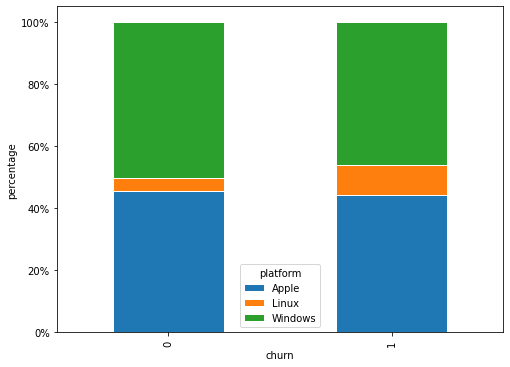

In [49]:
# plot the churn by platform information
pd_df = platform.toPandas()

pd_df = pd_df.pivot(index='churn', columns='platform', values='percent');
pd_df.plot.bar(stacked=True, figsize=(8,6), edgecolor='white');

# do some chart formatting
plt.ylabel("percentage");
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

**It looks like the Linux users are overrepresented in the churn population vs. in the non-churn population. We will display the information differently to confirm this information.**

In [50]:
# show the comparison information in a more visual format
platform_churn = platform.filter(platform["churn"]==1).select(["platform","percent"]).withColumnRenamed('percent','churn_percent')
platform_no_churn = platform.filter(platform["churn"]==0).select(["platform","percent"]).withColumnRenamed('percent','no_churn_percent')

# join the tables to be able to compare the data
compare_platform = platform_churn.join(platform_no_churn, on="platform", how="outer")
compare_platform = compare_platform.withColumn("ratio", col("churn_percent")/col("no_churn_percent")-1)

compare_platform.show()

+--------+-------------------+-------------------+--------------------+
|platform|      churn_percent|   no_churn_percent|               ratio|
+--------+-------------------+-------------------+--------------------+
|   Linux|0.09615384615384616|0.04046242774566474|  1.3763736263736264|
|   Apple| 0.4423076923076923|0.45664739884393063|-0.03140214216163584|
| Windows|0.46153846153846156| 0.5028901734104047|-0.08222811671087538|
+--------+-------------------+-------------------+--------------------+



In [51]:
# identify if we have users that use multiple platforms (i.e. bridge across Apple, Windows, Linux worlds)
# prepare a regex extraction function
re = regexp_extract("userAgent", r'[^(]*\(([^ ;]*)', 1).alias("platform")

# replace the common platforms with an aggregated dataset to identify the technology "world" the user lives in
platform_count = df.select(["userId", re]) \
    .replace(["iPad","iPhone","Macintosh","X11","Windows","compatible"],
             ["Apple","Apple","Apple","Linux","Windows","Windows"], "platform") \
    .dropDuplicates() \
    .groupBy(["userId", "platform"]).count() \
    .filter(col("count")>1)

platform_count.show()
platform_count.count()

+------+--------+-----+
|userId|platform|count|
+------+--------+-----+
+------+--------+-----+



0

**In our dataset we can see users are loyal to their platform of choice, and we have no cross-platform users**

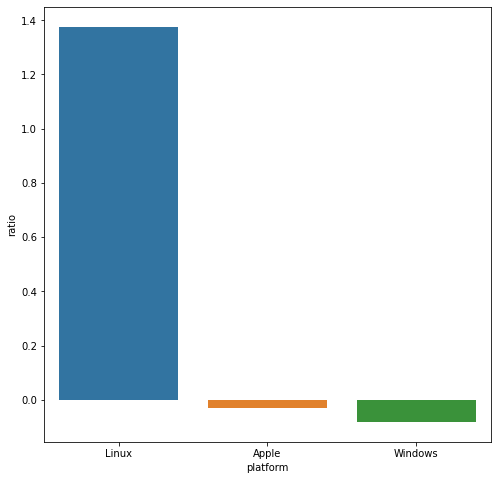

In [52]:
# plot the platforms that are more present in the group of "Churn" users
pd_df = compare_platform.toPandas().dropna()
fig=plt.figure(figsize=(8,8))
sns.barplot(x="platform", y="ratio", data=pd_df);

**It appears that the Linux users are indeed more likely to be present in the churn group.**

In [53]:
# count the number of songs played per hour on average between churn users and non-churn users
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
df = df.withColumn("hour", get_hour(df.ts))
songs_in_hour = df.filter(df.page == "NextSong").groupby(["userId", "churn", df.hour]).count().orderBy(["userId", df.hour.cast("float")])
songs_in_hour_avg = songs_in_hour.groupBy("churn").agg(avg("count"))

songs_in_hour_avg.show()

+-----+------------------+
|churn|        avg(count)|
+-----+------------------+
|    0| 56.95603089720737|
|    1|40.392896781354054|
+-----+------------------+



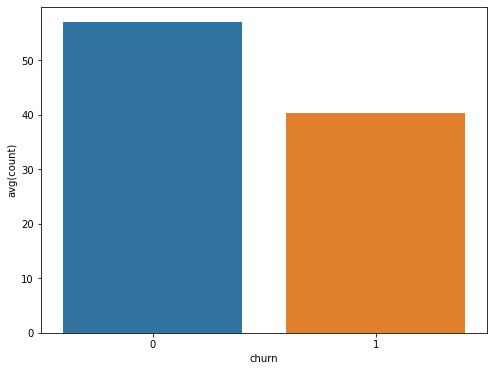

In [54]:
# plot the averages number of songs played per hour
pd_df = songs_in_hour_avg.toPandas()
fig=plt.figure(figsize=(8,6))
sns.barplot(x="churn", y="avg(count)", data=pd_df);

**The users who are ending up in the churn group, have a lower number of songs played per hour than the other users**

In [55]:
# comparison of the pages between the users who churn vs. users who do not churn
pages = df.groupBy(["churn","page"]).count() \
    .withColumn("percent", col("count")/Fsum("count").over(Window.partitionBy("churn"))) \
    .orderBy(["churn","percent"])

pages.show(40)

+-----+--------------------+------+--------------------+
|churn|                page| count|             percent|
+-----+--------------------+------+--------------------+
|    0|    Submit Downgrade|    54| 2.31471559003815E-4|
|    0|      Submit Upgrade|   127|5.443868146941575E-4|
|    0|               Error|   220|  9.4303227742295E-4|
|    0|       Save Settings|   252| 0.00108020060868447|
|    0|             Upgrade|   387|0.001658879506194...|
|    0|               About|   439|0.001881778044493...|
|    0|                Help|  1215|0.005208110077585837|
|    0|            Settings|  1244| 0.00533241887779159|
|    0|           Downgrade|  1718|0.007364224784602855|
|    0|         Thumbs Down|  2050|0.008787346221441126|
|    0|              Logout|  2673|0.011457842170688843|
|    0|         Roll Advert|  2966|0.012713789703802134|
|    0|          Add Friend|  3641|0.015607184191349823|
|    0|     Add to Playlist|  5488|0.023524368811350678|
|    0|                Home|  8

**We will have to filter out the "NextSong" page, as represent more than 80% of all the pages viewed and will not allow us to read the charts.**

/Users/mohammed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


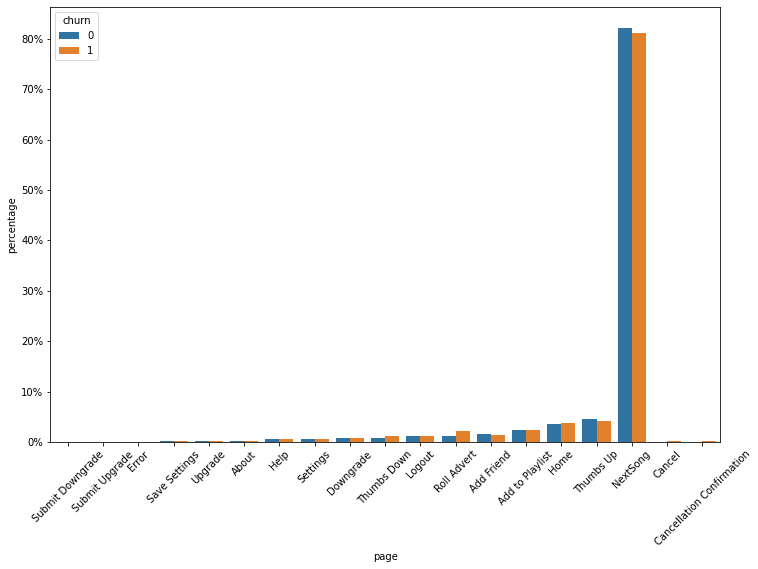

In [56]:
# plot the churn by pages information
pd_df = pages.toPandas()
fig=plt.figure(figsize=(12,8))
sns.barplot(x="page", y="percent", hue="churn", data=pd_df);
plt.xticks(rotation=45);

# do some chart formatting
plt.ylabel("percentage");
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

**The NextSong action dominates the dataset. We will be looking at the data from a different perspective, we would like to see what are the pages that are more seen by churn users vs. the non churn users**

In [57]:
# show the comparison information in a more visual format
pages_churn = pages.filter(pages["churn"]==1).select(["page","percent"]).withColumnRenamed('percent','churn_percent')
pages_no_churn = pages.filter(pages["churn"]==0).select(["page","percent"]).withColumnRenamed('percent','no_churn_percent')

# join the tables to be able to compare the data
compare_pages = pages_churn.join(pages_no_churn, on="page", how="outer")
compare_pages = compare_pages.withColumn("ratio", col("churn_percent")/col("no_churn_percent")-1)

compare_pages.show()

+--------------------+--------------------+--------------------+--------------------+
|                page|       churn_percent|    no_churn_percent|               ratio|
+--------------------+--------------------+--------------------+--------------------+
|              Cancel|0.001159058487874...|                null|                null|
|    Submit Downgrade|2.006062767475035...| 2.31471559003815E-4|-0.13334373514027587|
|         Thumbs Down|0.011055634807417974|0.008787346221441126|  0.2581312410841654|
|                Home|0.037268188302425106| 0.03604955205966823| 0.03380447670306208|
|           Downgrade|0.007511590584878745|0.007364224784602855| 0.02001104048100255|
|         Roll Advert|0.021554029957203995|0.012713789703802134|  0.6953269213473097|
|              Logout| 0.01232614122681883|0.011457842170688843| 0.07578207512329405|
|       Save Settings|0.001292796005706134| 0.00108020060868447| 0.19681103242533338|
|Cancellation Conf...|0.001159058487874...|           

/Users/mohammed/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


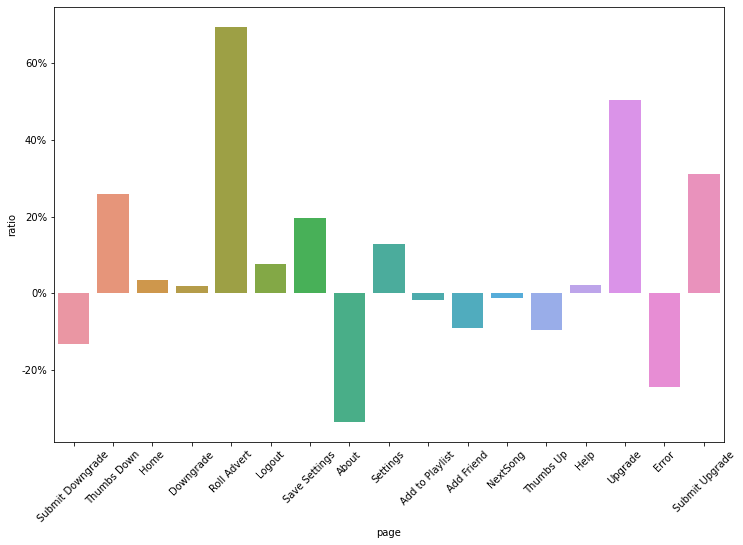

In [58]:
# plot the pages that are more viewed in the group of "Churn" users
pd_df = compare_pages.toPandas().dropna()
fig=plt.figure(figsize=(12,8))
sns.barplot(x="page", y="ratio", data=pd_df);
plt.xticks(rotation=45);

# do some chart formatting
plt.ylabel("ratio");
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]);

**In the chart above:**
* a value above 0 is the ratio of pages that are seen more frequently by the users in the churn group
* a value below 0 is the ratio of pages that are seen less frequently in the churn group.


**It looks like the following actions are significantly different in their frequency between the 2 groups of users:**

* number of Thumbs Down
* number of Thumbs Up
* number of Roll Advert
* number of Add Friend
* number of Add to Playlist
* number of Upgrade**

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.



**We will be selecting the following features that we believe could be useful to classify the data as per the analysis above:**

* gender (M/F)
* level (free/paid)
* number of different artist per user
* platform (Apple/Windows/Linux)
* number of songs per hour on average
* number of Thumbs Down
* number of Thumbs Up
* number of Roll Advert
* number of Add Friend
* number of Add to Playlist
* number of Upgrade

**Each of the single feature columns creation below will show a sample output, as well as the count of rows which should be equal to, or less than (if missing values) the total number of users. This acts as a validation to ensure we are not "multiplying rows" for users incorrectly in our transformations, otherwise the joining operation with all individual feature columns will be an issue if we get one of them incorrect in the process.**

**We will also check for each feature column that the engineered feature column is of a numeric type, since this is what the ML classifiers will be expecting.**

In [59]:
# gender (M/F)
df_gender = df.select(["userId", "gender"]).replace(["F","M"],["0","1"],"gender").dropDuplicates()

# need to convert the 0/1 values to integer number otherwise the spark models will fail
df_gender = df_gender.select("userId", df_gender.gender.cast(IntegerType()))

df_gender.show(5)
print("rows count: ", df_gender.count())
df_gender

+------+------+
|userId|gender|
+------+------+
|300001|     0|
|100023|     1|
|100024|     1|
|    78|     0|
|    97|     0|
+------+------+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, gender: int]

In [60]:
# level (free/paid)
# a user could have multiple levels during his lifetime, so here we will look at its LAST level as of the analysis
# (last row in the dataset ordered by time)
partition_window = Window.partitionBy(["userId"])

df_level = df.select(col("userId"), last("level").over(partition_window).alias("level"))
df_level = df_level.select(["userId", "level"]).replace(["free","paid"],["0","1"],"level").dropDuplicates()

# need to convert the 0/1 values to integer number otherwise the spark models will fail
df_level = df_level.select("userId", df_level.level.cast(IntegerType()))

df_level.show(5)
print("rows count: ", df_level.count())
df_level

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    1|
|   125|    0|
|   124|    1|
|    51|    1|
+------+-----+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, level: int]

In [61]:
# number of different artist per user
df_artists = df.filter(df["artist"].isNotNull()) \
    .select(["userId", "artist"]).dropDuplicates() \
    .groupBy("userId").agg(count("artist").alias("artists count")) \

df_artists.show(5)
print("rows count: ", df_artists.count())
df_artists

+------+-------------+
|userId|artists count|
+------+-------------+
|100010|          252|
|200002|          339|
|   125|            8|
|    51|         1385|
|   124|         2232|
+------+-------------+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, artists count: bigint]

In [62]:
# platform (Apple/Windows/Linux)
# prepare a regex extraction function
re = regexp_extract("userAgent", r'[^(]*\(([^ ;]*)', 1).alias("platform")

# replace the common platforms with an aggregated dataset to identify the technology "world" the user lives in
df_platform = df.select(["userId", re]) \
    .replace(["iPad","iPhone","Macintosh","X11","Windows","compatible"],
             ["Apple","Apple","Apple","Linux","Windows","Windows"], "platform").dropDuplicates()

# perform some form of one-hot-encoding using the groupBy to give a numeric '1' value for each user, or no entry if they do not use the platform
df_apple = df_platform.filter(col("platform") == "Apple").groupBy("userId").agg(count("platform").alias("apple"))
df_linux = df_platform.filter(col("platform") == "Linux").groupBy("userId").agg(count("platform").alias("linux"))
df_windows = df_platform.filter(col("platform") == "Windows").groupBy("userId").agg(count("platform").alias("windows"))

df_apple.show(5)
df_linux.show(5)
df_windows.show(5)
print("rows count: ", df_apple.count()+df_linux.count()+df_windows.count())

+------+-----+
|userId|apple|
+------+-----+
|100010|    1|
|200002|    1|
|   125|    1|
|   124|    1|
|   132|    1|
+------+-----+
only showing top 5 rows

+------+-----+
|userId|linux|
+------+-----+
|200010|    1|
|300013|    1|
|300007|    1|
|200024|    1|
|100016|    1|
+------+-----+
only showing top 5 rows

+------+-------+
|userId|windows|
+------+-------+
|    51|      1|
|     7|      1|
|    15|      1|
|    54|      1|
|   155|      1|
+------+-------+
only showing top 5 rows

rows count:  225


In [63]:
# number of songs per hour on average
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
df = df.withColumn("hour", get_hour(df.ts))

df_avg_songs = df.filter(df.page == "NextSong").groupby(["userId", df.hour]).count().groupBy("userId").agg(avg("count").alias("avg songs"))

df_avg_songs.show(5)
print("rows count: ", df_avg_songs.count())
df_avg_songs

+------+------------------+
|userId|         avg songs|
+------+------------------+
|200002| 20.36842105263158|
|100010|16.176470588235293|
|   125|               8.0|
|   124|169.95833333333334|
|    51| 87.95833333333333|
+------+------------------+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, avg songs: double]

In [64]:
# number of Thumbs Down
df_thumbs_down = df.filter(df["page"] == "Thumbs Down") \
    .groupBy("userId").count() \
    .select("userId", col("count").alias("thumbs down"))

df_thumbs_down.show(5)
print("rows count: ", df_thumbs_down.count())
df_thumbs_down

+------+-----------+
|userId|thumbs down|
+------+-----------+
|100010|          5|
|200002|          6|
|    51|         21|
|   124|         41|
|     7|          1|
+------+-----------+
only showing top 5 rows

rows count:  203


DataFrame[userId: string, thumbs down: bigint]

In [65]:
# number of Thumbs Up
df_thumbs_up = df.filter(df["page"] == "Thumbs Up") \
    .groupBy("userId").count() \
    .select("userId", col("count").alias("thumbs up"))

df_thumbs_up.show(5)
print("rows count: ", df_thumbs_up.count())
df_thumbs_up

+------+---------+
|userId|thumbs up|
+------+---------+
|100010|       17|
|200002|       21|
|    51|      100|
|   124|      171|
|     7|        7|
+------+---------+
only showing top 5 rows

rows count:  220


DataFrame[userId: string, thumbs up: bigint]

In [66]:
# number of Roll Advert
df_advert = df.filter(df["page"] == "Roll Advert") \
    .groupBy("userId").count() \
    .select("userId", col("count").alias("advert"))

df_advert.show(5)
print("rows count: ", df_advert.count())
df_advert

+------+------+
|userId|advert|
+------+------+
|100010|    52|
|200002|     7|
|   125|     1|
|     7|    16|
|   124|     4|
+------+------+
only showing top 5 rows

rows count:  207


DataFrame[userId: string, advert: bigint]

In [67]:
# number of Add Friend
df_add_friend = df.filter(df["page"] == "Add Friend") \
    .groupBy("userId").count() \
    .select("userId", col("count").alias("add friend"))

df_add_friend.show(5)
print("rows count: ", df_add_friend.count())
df_add_friend

+------+----------+
|userId|add friend|
+------+----------+
|100010|         4|
|200002|         4|
|    51|        28|
|   124|        74|
|     7|         1|
+------+----------+
only showing top 5 rows

rows count:  206


DataFrame[userId: string, add friend: bigint]

In [68]:
# number of Add to Playlist
df_add_playlist = df.filter(df["page"] == "Add to Playlist") \
    .groupBy("userId").count() \
    .select("userId", col("count").alias("add playlist"))

df_add_playlist.show(5)
print("rows count: ", df_add_playlist.count())
df_add_playlist

+------+------------+
|userId|add playlist|
+------+------------+
|100010|           7|
|200002|           8|
|    51|          52|
|   124|         118|
|     7|           5|
+------+------------+
only showing top 5 rows

rows count:  215


DataFrame[userId: string, add playlist: bigint]

In [69]:
# number of Upgrade
df_upgrade = df.filter(df["page"] == "Upgrade") \
    .groupBy("userId").count() \
    .select("userId", col("count").alias("upgrade"))

df_upgrade.show(5)
print("rows count: ", df_upgrade.count())
df_upgrade

+------+-------+
|userId|upgrade|
+------+-------+
|100010|      2|
|200002|      2|
|     7|      2|
|    54|      1|
|   155|      2|
+------+-------+
only showing top 5 rows

rows count:  168


DataFrame[userId: string, upgrade: bigint]

In [70]:
# identify churn as the label
df_churn = df.select(["userId", "churn"]).dropDuplicates()

df_churn.show(5)
print("rows count: ", df_churn.count())
df_churn

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows

rows count:  225


DataFrame[userId: string, churn: bigint]

In [71]:
# merge all the individual features into a single dataframe
df_features = df_gender \
    .join(df_level, on="userId", how="outer") \
    .join(df_artists, on="userId", how="outer") \
    .join(df_apple, on="userId", how="outer") \
    .join(df_linux, on="userId", how="outer") \
    .join(df_windows, on="userId", how="outer") \
    .join(df_avg_songs, on="userId", how="outer") \
    .join(df_thumbs_down, on="userId", how="outer") \
    .join(df_thumbs_up, on="userId", how="outer") \
    .join(df_advert, on="userId", how="outer") \
    .join(df_add_friend, on="userId", how="outer") \
    .join(df_add_playlist, on="userId", how="outer") \
    .join(df_upgrade, on="userId", how="outer") \
    .join(df_churn, on="userId", how="outer")

df_features.show()
print("rows count: ", df_features.count())
df_features

+------+------+-----+-------------+-----+-----+-------+------------------+-----------+---------+------+----------+------------+-------+-----+
|userId|gender|level|artists count|apple|linux|windows|         avg songs|thumbs down|thumbs up|advert|add friend|add playlist|upgrade|churn|
+------+------+-----+-------------+-----+-----+-------+------------------+-----------+---------+------+----------+------------+-------+-----+
|100010|     0|    0|          252|    1| null|   null|16.176470588235293|          5|       17|    52|         4|           7|      2|    0|
|200002|     1|    1|          339|    1| null|   null| 20.36842105263158|          6|       21|     7|         4|           8|      2|    0|
|   125|     1|    0|            8|    1| null|   null|               8.0|       null|     null|     1|      null|        null|   null|    1|
|   124|     0|    1|         2232|    1| null|   null|169.95833333333334|         41|      171|     4|        74|         118|   null|    0|
|    5

DataFrame[userId: string, gender: int, level: int, artists count: bigint, apple: bigint, linux: bigint, windows: bigint, avg songs: double, thumbs down: bigint, thumbs up: bigint, advert: bigint, add friend: bigint, add playlist: bigint, upgrade: bigint, churn: bigint]

In [72]:
# remove the null values in the final dataframe as not all values are filled in for all users
df_features = df_features.fillna(0)

df_features.show()
df_features

+------+------+-----+-------------+-----+-----+-------+------------------+-----------+---------+------+----------+------------+-------+-----+
|userId|gender|level|artists count|apple|linux|windows|         avg songs|thumbs down|thumbs up|advert|add friend|add playlist|upgrade|churn|
+------+------+-----+-------------+-----+-----+-------+------------------+-----------+---------+------+----------+------------+-------+-----+
|100010|     0|    0|          252|    1|    0|      0|16.176470588235293|          5|       17|    52|         4|           7|      2|    0|
|200002|     1|    1|          339|    1|    0|      0| 20.36842105263158|          6|       21|     7|         4|           8|      2|    0|
|   125|     1|    0|            8|    1|    0|      0|               8.0|          0|        0|     1|         0|           0|      0|    1|
|   124|     0|    1|         2232|    1|    0|      0|169.95833333333334|         41|      171|     4|        74|         118|      0|    0|
|    5

DataFrame[userId: string, gender: int, level: int, artists count: bigint, apple: bigint, linux: bigint, windows: bigint, avg songs: double, thumbs down: bigint, thumbs up: bigint, advert: bigint, add friend: bigint, add playlist: bigint, upgrade: bigint, churn: bigint]

In [73]:
df_features.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- artists count: long (nullable = true)
 |-- apple: long (nullable = true)
 |-- linux: long (nullable = true)
 |-- windows: long (nullable = true)
 |-- avg songs: double (nullable = false)
 |-- thumbs down: long (nullable = true)
 |-- thumbs up: long (nullable = true)
 |-- advert: long (nullable = true)
 |-- add friend: long (nullable = true)
 |-- add playlist: long (nullable = true)
 |-- upgrade: long (nullable = true)
 |-- churn: long (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.


**We will now split the full dataset into train, test, and validation sets. We will test out a few machine learning methods and evaluate their accuracy using the F1 score as the metric to optimize. This is due to the fact the churned users are quite a small subset of the data.**

**The models we will be using are:**

- Random Forest Classifier
- Logistic Regression
- Gradient-Boosted Trees
- Multiplayer Perceptron Classifier

**We will then identify the model that gives the highest accuracy, run it with different parameters to try to optimise it further and finally evaluate the model with tuned parameters on the validation set.**

In [75]:
# Split the feature set into train (60%), test (20%) and validation (20%) sets
train, test, valid = df_features.randomSplit([0.6, 0.2, 0.2], 1234)

print("samples in train set:", train.count())
print("samples in test set:", test.count())
print("samples in validation set:", valid.count())

samples in train set: 123
samples in test set: 49
samples in validation set: 53


In [76]:
# combine the features into a vector
input_cols = df_features.columns
input_cols.remove("userId")    # remove this string value as it is not useful for the classification
input_cols.remove("churn")     # remove the label as it will be handled separately

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
input_cols

['gender',
 'level',
 'artists count',
 'apple',
 'linux',
 'windows',
 'avg songs',
 'thumbs down',
 'thumbs up',
 'advert',
 'add friend',
 'add playlist',
 'upgrade']

In [77]:
# our pipeline will use normalization to ensure data for different features is comparable
scaler = Normalizer(inputCol="features", outputCol="scaled_features")

### Model 1: Random Forest Classifier

In [78]:
# create a Random Forest classifier
rf = RandomForestClassifier(labelCol="churn", featuresCol="scaled_features", seed=1234)

In [79]:
# build pipeline
rf_pipeline = Pipeline(stages = [assembler, scaler, rf])

# train the model
model = rf_pipeline.fit(train)

# predict churn
preds = model.transform(test)

In [80]:
# Select example rows to display.
preds.select("prediction", "churn").show()

+----------+-----+
|prediction|churn|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
+----------+-----+
only showing top 20 rows



In [81]:
# Select (prediction, true label) and compute f1 score
evaluator = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1")

# show the F1 score
rf_score = evaluator.evaluate(preds)
print("f1 score: ", rf_score)

# compute the accuracy
rf_accuracy = preds.filter(preds.churn == preds.prediction).count() / preds.count()
print("accuracy: ", rf_accuracy)

f1 score:  0.7716229348882411
accuracy:  0.7959183673469388


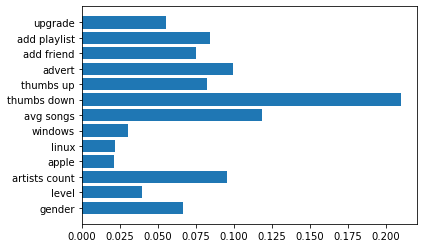

In [82]:
# display the features importance for the model
rf_model = model.stages[2].featureImportances
plt.barh(y=input_cols, width=rf_model.values);

### Model 2: Logistic Regression

In [83]:
# create a Logistic Regression
lr = LogisticRegression(labelCol="churn", featuresCol="scaled_features")

In [84]:
# build pipeline
lr_pipeline = Pipeline(stages = [assembler, scaler, lr])

# train the model
model = lr_pipeline.fit(train)

# predict churn
preds = model.transform(test)

In [85]:
# Select example rows to display.
preds.select("prediction", "churn").show()

+----------+-----+
|prediction|churn|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
+----------+-----+
only showing top 20 rows



In [86]:
# Select (prediction, true label) and compute f1 score
evaluator = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1")

# show the F1 score
lr_score = evaluator.evaluate(preds)
print("f1 score: ", lr_score)

# compute the accuracy
lr_accuracy = preds.filter(preds.churn == preds.prediction).count() / preds.count()
print("accuracy: ", lr_accuracy)

f1 score:  0.7024205030849549
accuracy:  0.7551020408163265


intercept vector:  [-1.0770414225017533]


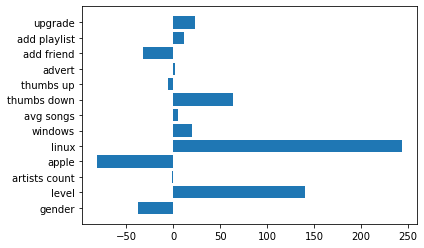

In [87]:
# display the coefficients for the model
lr_model = model.stages[2].coefficientMatrix
plt.barh(y=input_cols, width=lr_model.values);

print("intercept vector: ", model.stages[2].interceptVector)

### Model 3: Gradient-Boosted Trees Classifier

In [88]:
# create a Gradient-Boosted Trees classifier
gbt = GBTClassifier(labelCol="churn", featuresCol="scaled_features", seed=1234)

In [89]:
# build pipeline
gbt_pipeline = Pipeline(stages = [assembler, scaler, gbt])

# train the model
model = gbt_pipeline.fit(train)

# predict churn
preds = model.transform(test)

In [90]:
# Select example rows to display.
preds.select("prediction", "churn").show()

+----------+-----+
|prediction|churn|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       1.0|    0|
|       0.0|    0|
|       0.0|    0|
+----------+-----+
only showing top 20 rows



In [91]:
# Select (prediction, true label) and compute f1 score
evaluator = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1")

# show the F1 score
gbt_score = evaluator.evaluate(preds)
print("f1 score: ", gbt_score)

# compute the accuracy
gbt_accuracy = preds.filter(preds.churn == preds.prediction).count() / preds.count()
print("accuracy: ", gbt_accuracy)

f1 score:  0.7702933025061878
accuracy:  0.7755102040816326


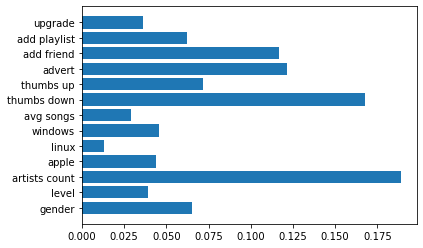

In [92]:
# display the features importance for the model
gbt_model = model.stages[2].featureImportances
plt.barh(y=input_cols, width=gbt_model.values);

### Model 4: Multilayer Perceptron Classifier

In [93]:
# create a Multilayer Perceptron classifier
mlp = MultilayerPerceptronClassifier(labelCol="churn", featuresCol="scaled_features", layers=[13, 25, 25, 10, 2], seed=1234)

In [94]:
# build pipeline
mlp_pipeline = Pipeline(stages = [assembler, scaler, mlp])

# train the model
model = mlp_pipeline.fit(train)

# predict churn
preds = model.transform(test)

In [95]:
# Select example rows to display.
preds.select("prediction", "churn").show()

+----------+-----+
|prediction|churn|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       1.0|    1|
|       0.0|    1|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
+----------+-----+
only showing top 20 rows



In [96]:
# Select (prediction, true label) and compute f1 score
evaluator = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1")

# show the F1 score
mlp_score = evaluator.evaluate(preds)
print("f1 score: ", mlp_score)

# compute the accuracy
mlp_accuracy = preds.filter(preds.churn == preds.prediction).count() / preds.count()
print("accuracy: ", mlp_accuracy)

f1 score:  0.8172983479105927
accuracy:  0.8367346938775511


In [97]:
# display the network weights
mlp_model = model.stages[2].weights
mlp_model

DenseVector([0.5963, 0.7251, -0.1248, -1.2703, 0.6927, 0.1433, -1.7031, -0.0006, -0.1362, 0.4171, 0.471, -0.9853, -0.3195, -0.5694, -0.364, 0.2846, -0.7046, 0.7312, 0.0552, -0.764, -0.9726, 0.4515, -0.7656, 0.4021, -1.4817, -2.7623, 1.5432, 0.296, -1.2601, 1.0163, -0.1509, 0.9402, 0.4146, 0.2096, 1.4046, -0.9857, -1.0544, -0.9168, -2.0227, -0.5067, 0.5104, 1.1027, 2.0234, -2.0827, 1.1012, 1.6865, -0.5221, -1.9525, -0.4567, -2.3895, 9.4373, -3.3947, 4.303, 6.1095, -12.6995, -0.4749, 0.4118, -0.5639, 2.0847, -3.4227, 1.5485, 3.3947, 4.1246, 9.206, -0.0751, -1.4127, -0.437, -21.9135, 5.3626, -0.0098, 0.4449, -3.4578, 6.3245, -4.324, 9.1223, 1.2075, -0.3768, 0.0913, 0.8538, -0.3842, 0.1145, 0.153, -0.73, 0.3862, -1.0105, 0.4043, 1.0253, 0.3893, 1.641, 0.5597, -0.0614, -0.7798, -1.5454, 0.3373, 0.1593, -1.104, 0.6184, 1.4732, -0.3035, 0.699, -5.1375, 2.0034, -0.2091, -0.781, 2.2438, 0.2144, 0.6738, 0.597, 0.397, 1.1848, -1.2633, -1.4768, -1.4839, -4.4376, -0.9929, 1.7989, 0.9915, 4.6791, -2

### Tuning Random Forest classifier

In [98]:
# build the parameters grid
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.impurity, ['gini', 'entropy']) \
    .addGrid(rf.maxDepth, [5, 15, 30]) \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .build()

In [99]:
# create the cross validator
rf_crossval = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1"),
                          numFolds=3)

# run the models
rf_cvModel = rf_crossval.fit(train)
rf_cvModel.avgMetrics

[0.6349788011906644,
 0.6467920726694636,
 0.6337747658402876,
 0.6349788011906644,
 0.6421184709809367,
 0.6434998063872015,
 0.6349788011906644,
 0.6421184709809367,
 0.6434998063872015,
 0.6624954327279295,
 0.6297090795937246,
 0.6467920726694636,
 0.6624954327279295,
 0.6254421398429139,
 0.6373010661635318,
 0.6624954327279295,
 0.6254421398429139,
 0.6373010661635318]

In [100]:
rf_tuned_score = max(rf_cvModel.avgMetrics)
rf_tuned_score

0.6624954327279295

In [101]:
# compute predictions using the tuned model
preds = rf_cvModel.transform(test)

# compute the accuracy on the test set
rf_tuned_accuracy = preds.filter(preds.churn == preds.prediction).count() / preds.count()
print("accuracy: ", rf_tuned_accuracy)

accuracy:  0.8367346938775511


In [102]:
# show details about the best model from the tuning
bestPipeline = rf_cvModel.bestModel
bestRFModel = bestPipeline.stages[2]
bestRFModel.extractParamMap()

{Param(parent='RandomForestClassifier_711b4b6496db', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_711b4b6496db', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_711b4b6496db', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_711b4b6496db', name='featuresCol', doc='features column name'): 'scaled_features',
 Param(parent='RandomForestClassifier_711b4b64

### Tuning Multilayer perceptron classifier

In [103]:
# build the parameters grid. In our case we will only adjust the layers to assess impact, and select the best model.
mlp_paramGrid = ParamGridBuilder() \
    .addGrid(mlp.layers, [[13, 25, 10, 2], 
                          [13, 25, 25, 10, 2],
                          [13, 25, 25, 25, 10, 2], 
                          [13, 40, 80, 60, 20, 8, 2]]) \
    .build()

In [104]:
# create the cross validator
mlp_crossval = CrossValidator(estimator=mlp_pipeline,
                          estimatorParamMaps=mlp_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1"),
                          numFolds=3)

# run the models
mlp_cvModel = mlp_crossval.fit(train)
mlp_cvModel.avgMetrics

[0.6844795201006595,
 0.6352535170797429,
 0.6673223468336211,
 0.6550168860569197]

In [105]:
mlp_tuned_score = max(mlp_cvModel.avgMetrics)
mlp_tuned_score

0.6844795201006595

In [106]:
# compute predictions using the tuned model
preds = mlp_cvModel.transform(test)

# compute the accuracy on the test set
mlp_tuned_accuracy = accuracy = preds.filter(preds.churn == preds.prediction).count() / preds.count()
print("accuracy: ", mlp_tuned_accuracy)

accuracy:  0.7959183673469388


In [107]:
# show details about the best model from the tuning
bestPipeline = mlp_cvModel.bestModel
bestMLPModel = bestPipeline.stages[2]
bestMLPModel.layers

[13, 25, 10, 2]

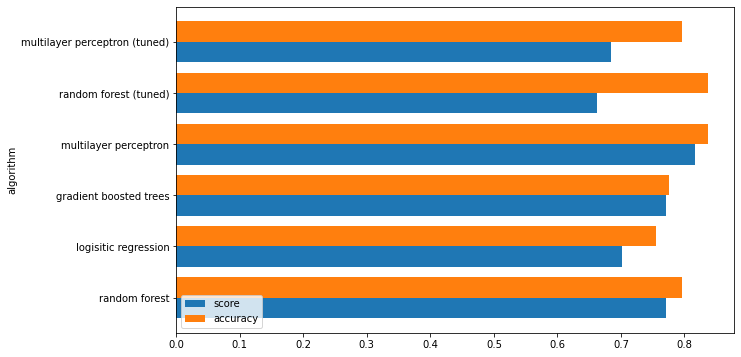

In [108]:
# display a summary of all the models performance
summary = [[rf_score, rf_accuracy], \
           [lr_score, lr_accuracy], \
           [gbt_score, gbt_accuracy], \
           [mlp_score, mlp_accuracy], \
           [rf_tuned_score, rf_tuned_accuracy], \
           [mlp_tuned_score, mlp_tuned_accuracy]]

summary_df = pd.DataFrame(summary, columns=['score','accuracy'], \
                          index=['random forest', 'logisitic regression', 'gradient boosted trees', 'multilayer perceptron', 'random forest (tuned)', 'multilayer perceptron (tuned)'])

import numpy as np
y = np.arange(len(summary_df.index))
height = 0.4
fig, ax = plt.subplots(figsize=(10,6))
plt_score = ax.barh(y - height/2, summary_df.score, height, label='score')
plt_accuracy = ax.barh(y + height/2, summary_df.accuracy, height, label='accuracy')
ax.set_ylabel('algorithm')
ax.set_yticks(y)
ax.set_yticklabels(summary_df.index)
ax.legend(loc="lower left");

**The best model after tuning in our situation is the Multilayer Perceptron classifier, which got a higher F1 score. We are now evaluating its accuracy on the validation dataset.**

In [109]:
# compute predictions using the tuned model
preds = mlp_cvModel.transform(valid)

# compute the accuracy on the validation set
accuracy = preds.filter(preds.churn == preds.prediction).count() / preds.count()
print("accuracy: ", accuracy)

accuracy:  0.7735849056603774


In [110]:
# check number of churn vs. non-churn users in the validation set
print("number of non-churn users: ", preds[preds.churn == 0].count())
print("total number of users: ", preds.count())

number of non-churn users:  41
total number of users:  53


# Conclusion:

**After running the best model on the validation data, we managed to achieve an accuracy of 79.2%. This results is quite good, based on the small size of our dataset, and the relative small portion of churn users in the dataset. That latter point is also the reason why we optimised the model on the F1 metric, as otherwise a dumb model which would only output zero as a prediction would still be able to get a high accuracy even though it would not generate any real positive, but would generate a lot of false negatives instead. In theory this dumb classifier would get a 77.3% on the validation set : 41 (=non-churn users) / 53 (=total number of users). The successful model is the Multilayer Perceptron classifier. I could not manage to get to a higher accuracy by tuning the model.**